## Data acquisition

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
from matplotlib.gridspec import GridSpec
from lmfit.models import GaussianModel
from scipy.signal import find_peaks
from scipy import optimize as optim

import sys
sys.path.append('Library')

import drop_detection_tools as ddt


from importlib import reload


from tqdm import tqdm
%matplotlib inline

In [2]:
matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

<Figure size 432x288 with 0 Axes>

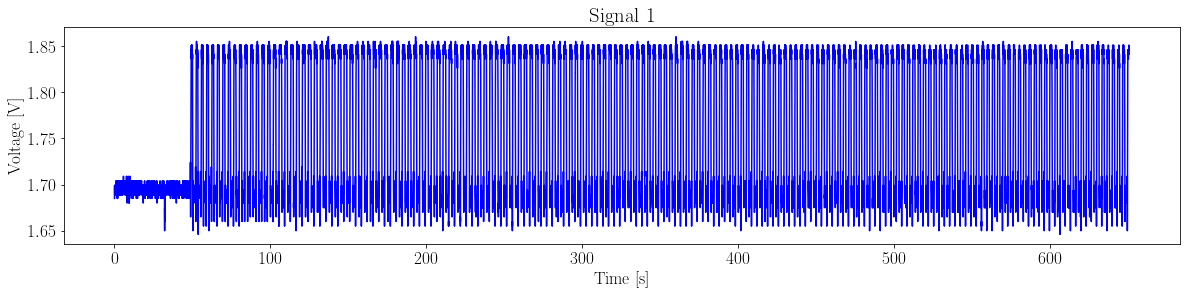

<Figure size 432x288 with 0 Axes>

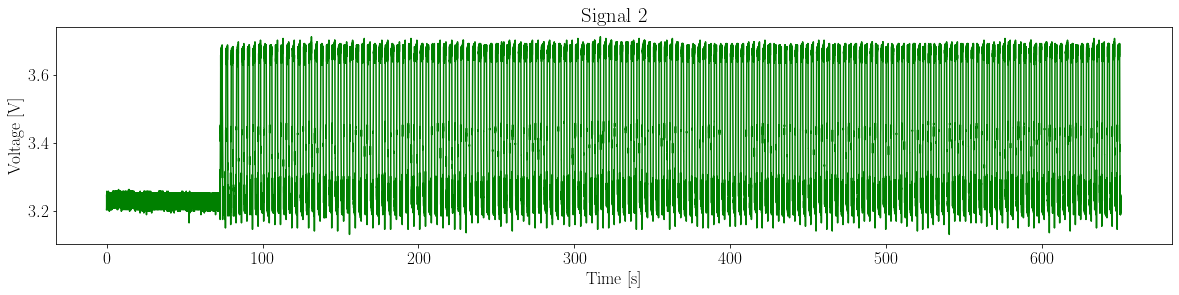

In [3]:
#************************************
folder   = '../../T-data/2-12/'
filename = 'B-ol5-aq5-pause10.csv'
name     = '2-12_B-ol5-aq5'
#************************************

raw = True 
sig1, sig2, t = ddt.read_LV(folder, filename)

### Resample data

(170.0, 200.0)

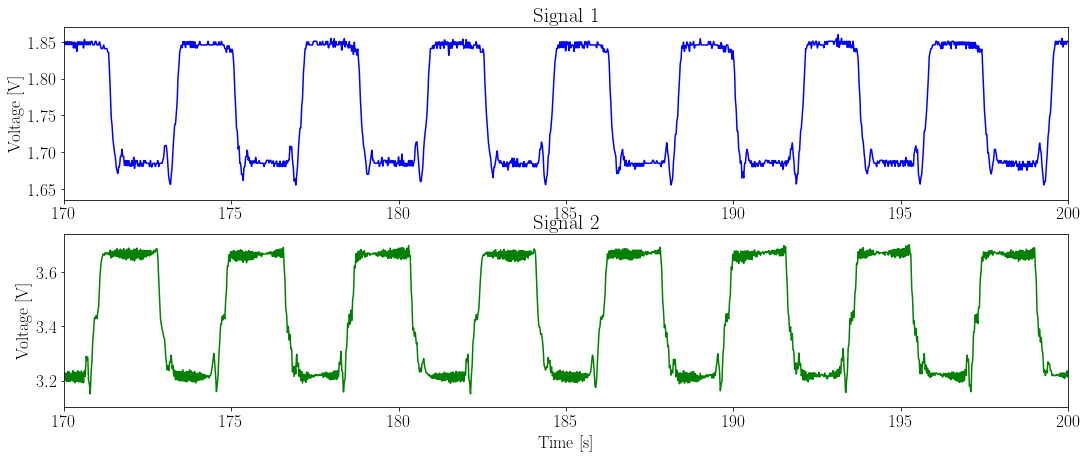

In [4]:
#******************************
dt = 0.01  # sampling time [s]
#******************************

# Resampling of the two signals
if raw:
    sig1, new_t = ddt.resample(sig1, t, dt=dt)
    sig2, _     = ddt.resample(sig2, t, dt=dt)
    t           = new_t
    raw         = False 
else:
    print('data already resampled')

    
# Signals plots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18,7))

# Signal 1
axs[0].plot(t, sig1, color='blue')
axs[0].set_title('Signal 1')
axs[0].set_ylabel('Voltage [V]')
#axs[0].set_xlabel('Time [s]')
axs[0].set_xlim(170,200)

# Signal 2
axs[1].plot(t, sig2, color='green')
axs[1].set_title('Signal 2')
axs[1].set_ylabel('Voltage [V]')
axs[1].set_xlabel('Time [s]')
axs[1].set_xlim(170,200)


## Fourier transformation


In [5]:
min_freq  = 1       # lower cut-off frequency
max_freq  = 6000    # higher cut-off frequency

### Signal 1 

E:\Programmi\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
E:\Programmi\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


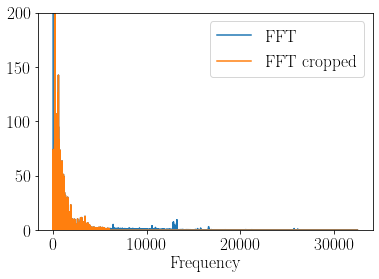

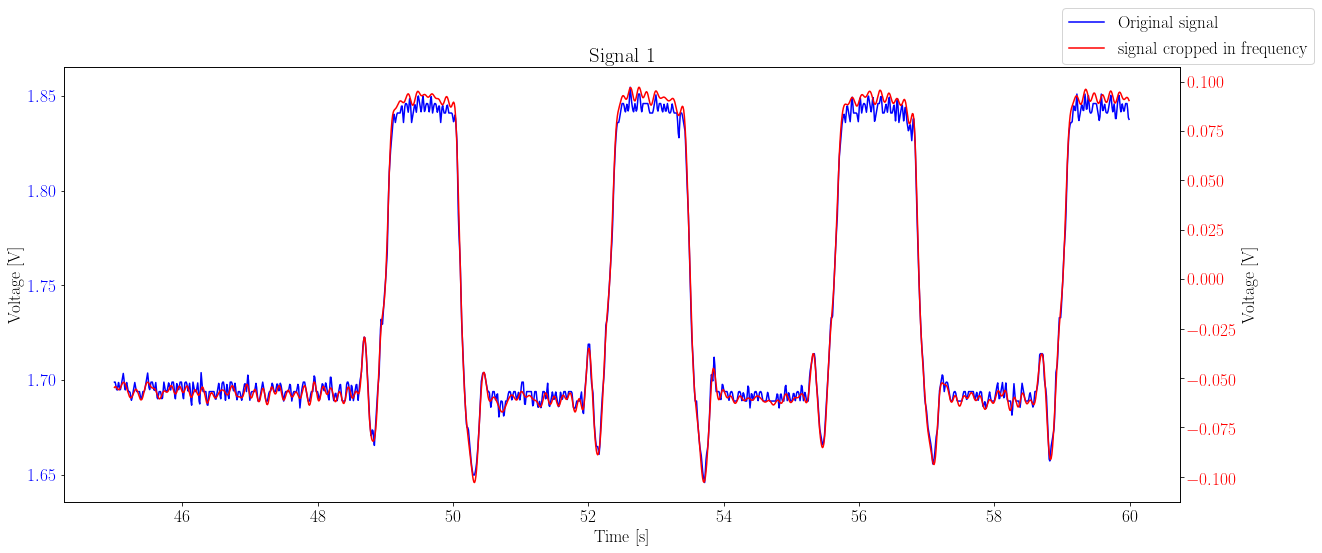

In [6]:
#*************************************
x_min = 4500 # signal plot x min. [s]
x_max = 6000 # signal plot x max. [s]
#*************************************

# FFT transform filtering
sig1_high = ddt.FFT_cropping(sig1, min_freq, max_freq)

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,8))

# Signal plot
color = 'blue'
ax1.set_title('Signal 1')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Voltage [V]')
ax1.plot(t[x_min:x_max], sig1[x_min:x_max], color = color, label='Original signal')
ax1.tick_params(axis = 'y', labelcolor = color)

# Filtered signal plot
color = 'red'
ax2 = ax1.twinx()   
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Voltage [V]')                     
ax2.plot(t[x_min:x_max], sig1_high[x_min:x_max], color = color, label='signal cropped in frequency')
ax2.tick_params(axis = 'y', labelcolor = color)
fig.legend()


### Signal 2 

E:\Programmi\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
E:\Programmi\Anaconda\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


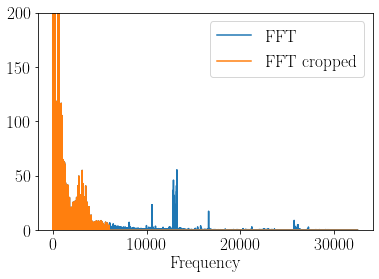

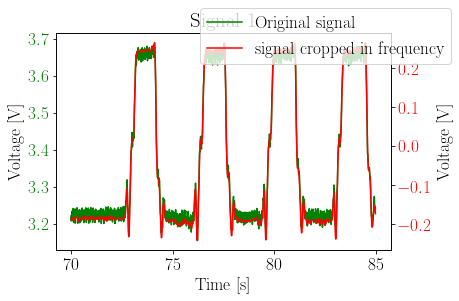

In [7]:
#*************************************
x_min = 7000 # signal plot x min. [s]
x_max = 8500 # signal plot x max. [s]
#*************************************

# FFT transform filtering
sig2_high = ddt.FFT_cropping(sig2, min_freq, max_freq)

fig, ax1 = plt.subplots(nrows=1, ncols=1)

# Signal plot
color = 'green'
ax1.set_title('Signal 1')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Voltage [V]')
ax1.plot(t[x_min:x_max], sig2[x_min:x_max], color = 'green', label='Original signal')
ax1.tick_params(axis = 'y', labelcolor = color)
ax1.set_xlim()

# Filtered signal plot
color = 'red'
ax2 = ax1.twinx()   
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Voltage [V]')                     
ax2.plot(t[x_min:x_max], sig2_high[x_min:x_max], color = 'red', label='signal cropped in frequency')
ax2.tick_params(axis = 'y', labelcolor = color)
fig.legend()


## Rectification

In [8]:
def bell_func(x, c, a, lam, b):
    return a*np.tanh((x-c)/lam) + b

In [109]:
# rectification
def rectify(signal, fit_func, xdata=None, plot_switch=False, ignore_bias=-1, **kwargs):
    
    # Parameters and bounds
    p0     = kwargs.pop('p0', None)
    bounds = kwargs.pop('bounds', None)
    if bounds is None:
        bounds = (-np.inf, np.inf)
    
    # Y-data
    signal = np.array(signal)
    
    # X-data
    if xdata is None:
        xdata = np.arange(len(signal))
    else:
        xdata = np.array(xdata)
    
    # Analysis
    main_mean  = np.mean(signal)
    lower_mean = np.mean([s for s in signal if s < main_mean])
    upper_mean = np.mean([s for s in signal if s >= main_mean])
    pivot      = 0.5*(lower_mean + upper_mean)
    z_sig      = signal - pivot
    fit_mask   = [(s > ignore_bias) for s in np.abs(z_sig)]
    
    # Fit
    popt, pcov = optim.curve_fit(fit_func, xdata[fit_mask], np.abs(z_sig)[fit_mask], p0=p0, bounds=bounds)
    fit_curve  = fit_func(xdata,*popt)
    
    # Normalization
    n_sig = z_sig/fit_curve
    
    # Labels
    main_mean_label  = "$\overline{\rV}$"          
    lower_mean_label = "$\overline{\rV}_{down}$"
    upper_mean_label = "$\overline{\rV}_{up}$"    
    pivot_label      = "$\overline{\rV}_{pivot}$" 
    
    # Plots
    fig = None
    if plot_switch:
        
        # Thresholds plot
        fig,axs = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
        axs.plot(xdata, signal, color='green')
        axs.plot(xdata, main_mean*np.ones(len(xdata)), 'r--',   label=main_mean_label)
        axs.plot(xdata, lower_mean*np.ones(len(xdata)), color='cyan',   label=lower_mean_label)
        axs.plot(xdata, upper_mean*np.ones(len(xdata)), color='yellow', label=upper_mean_label)
        axs.plot(xdata, pivot*np.ones(len(xdata)), color='red', label=pivot_label)
        axs.set_xlabel('Time [s]')
        axs.set_ylabel('Voltage [V]') 
        fig.legend(loc='center right')
        
        # Signal vs abs(z_sig) plot
        fig,axs = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
        axs.plot(xdata, signal, color = 'green', label = 'signal')
        axs.plot(xdata, np.abs(z_sig), color='blue', label = '$|$signal -$\overline{\rV}_{pivot}|$')
        axs.set_xlabel('Time [s]')
        axs.set_ylabel('Voltage [V]') 
        fig.legend(loc='center right')
        
        # Fit plot
        fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        axs[0].plot(xdata, signal, color = 'green')
        axs[0].plot(xdata[fit_mask], np.abs(z_sig)[fit_mask], color='blue')
        axs[0].plot(xdata, fit_curve, color='orange')
        axs[0].set_xlabel('Time [s]')
        axs[0].set_ylabel('Voltage [V]')
        axs[1].plot(xdata, signal, color = 'green', label = 'signal')
        axs[1].plot(xdata[fit_mask], np.abs(z_sig)[fit_mask], color='blue', label='$|$signal -$\overline{\rV}_{pivot}|$ cropped')
        axs[1].plot(xdata, fit_curve, color='orange', label = 'best fit')
        axs[1].set_xlabel('Time [s]')
        axs[1].set_ylabel('Voltage [V]')
        axs[1].set_xlim(45,60)
        axs[1].set_ylim(0.04,0.12)
        fig.legend(loc='center right')
        
        # Normalized signal plot
        fig,axs = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
        axs.plot(xdata, signal, color='green', label='signal')
        axs.set_xlabel('Time [s]')
        axs.set_ylabel('Voltage [V]') 
        ax2 = axs.twinx()
        ax2.plot(xdata, n_sig, color='red', label='normalized signal')
        ax2.tick_params(axis = 'y', labelcolor = 'red')
        ax2.set_ylabel('Voltage [V]') 
        fig.legend()
    
    return fig, n_sig

### Signal 1 

<IPython.core.display.Javascript object>


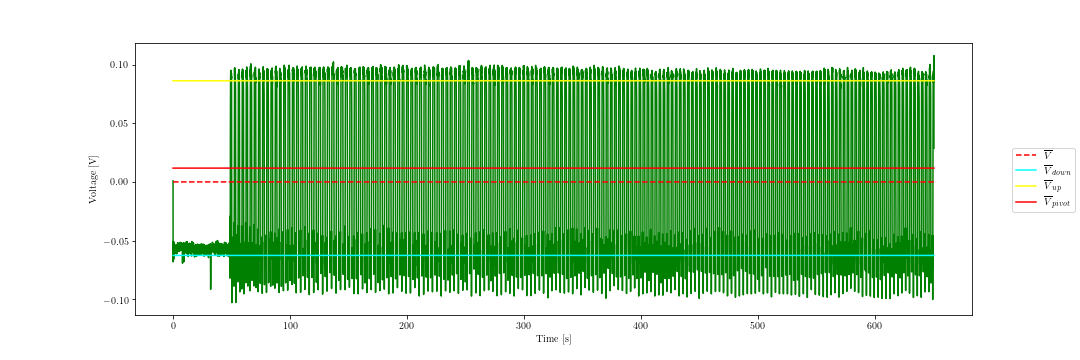

<IPython.core.display.Javascript object>


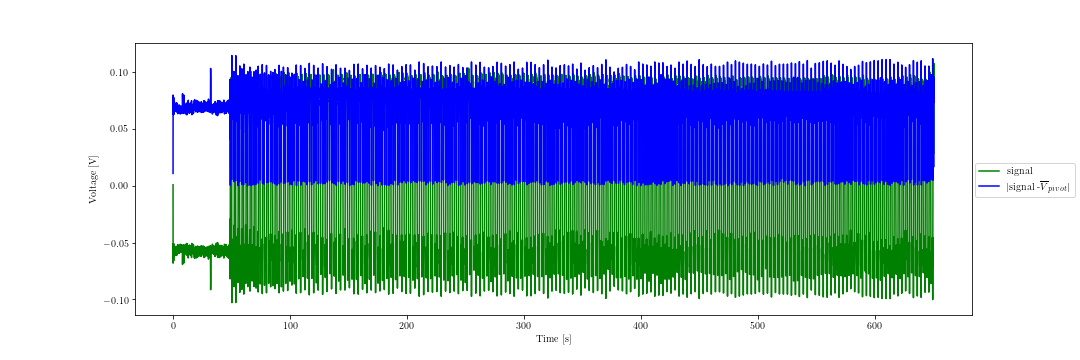

<IPython.core.display.Javascript object>


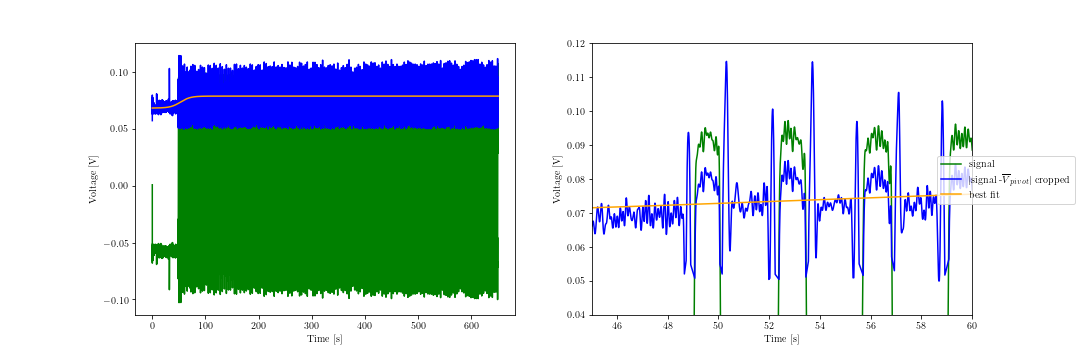

<IPython.core.display.Javascript object>


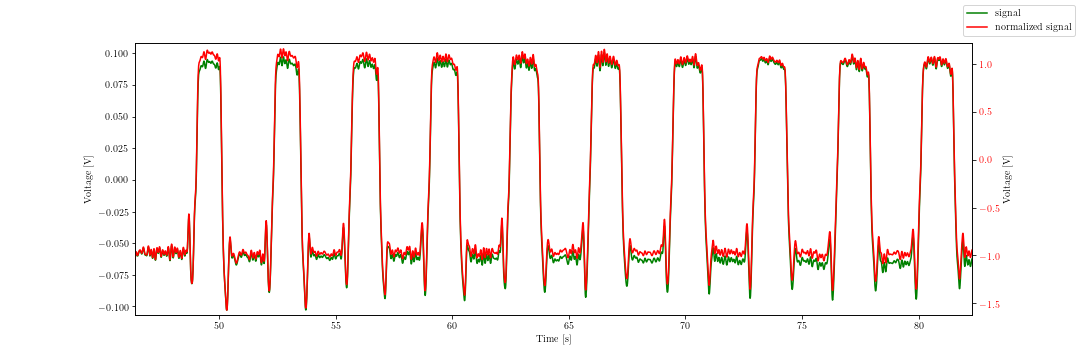

In [110]:
%matplotlib notebook
#%matplotlib notebook

fig, r_sig = rectify(sig1_high, bell_func, xdata = t, plot_switch=True, p0=[70,0.02,1000,0.22],
                      bounds=([50,0,0,0], [100,1,100000,0.3]), ignore_bias=0.05)

##### Signal 2 

<IPython.core.display.Javascript object>


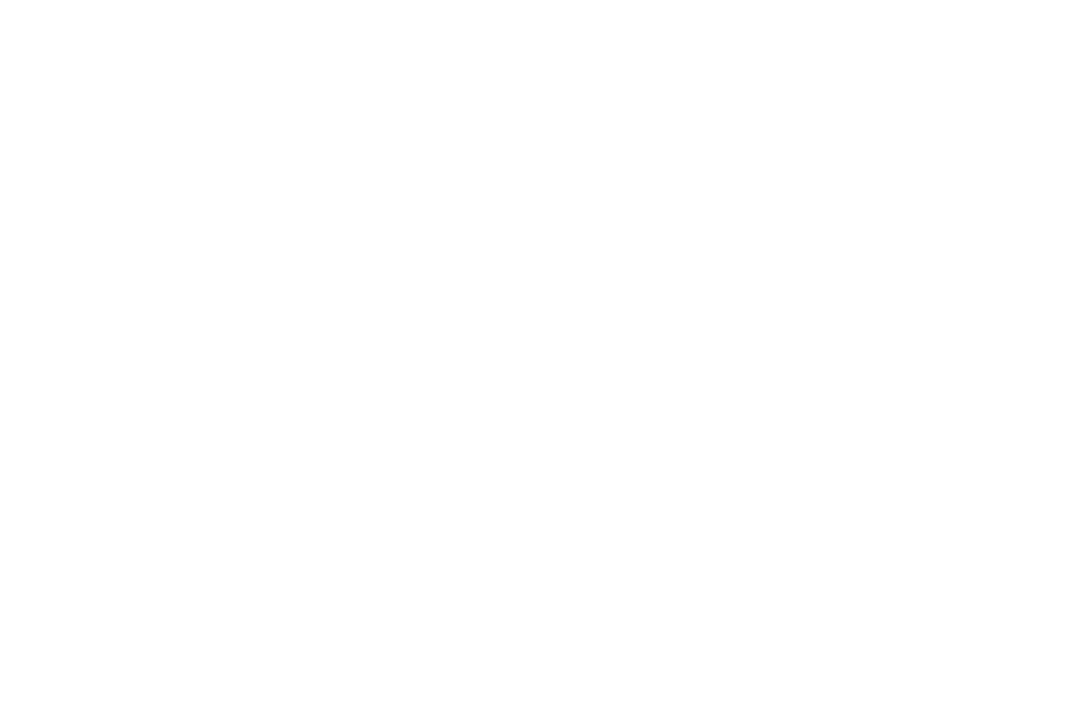

In [11]:
%matplotlib notebook
# %matplotlib notebook

fig, r_sig2 = rectify(sig2_high, bell_func, plot_switch=True, p0=[70,0.02,1000,0.22],
                      bounds=([50,0,0,0], [100,1,100000,0.3]), ignore_bias=0.175)

## Thresholds searching 

In [12]:
def thr_searcher(Ydata, nbins=20, low_sigmas=3, high_sigmas=5, plot_switch=True, Xdata=None, ymin=None, ymax=None, c01=None, c02=None):
    
    '''
    Description:
        Oscillating data finds the two threshold to identify peaks (droplets)
    
    Params:
        - Ydata:       array with oscillating data
        - nbins:       number of bins for the histogram to find the two thresholds
        - low_sigmas:  number of sigmas above the low mean where to put the lower thr
        - high_sigmas: number of sigmas below the high mean where to put the higher thr
        - plot_switch: if True shows plots
        - Xdata:       array with the matching time (or space) to the data
        - ymin, ymax:  ylims for the plot
        
    Returns:
        thr_low, thr_high
    '''
    
    if plot_switch:
        #plt.clf() # Clear figure
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        freq,bins,p = axes[0].hist(Ydata, nbins)
    
    # Histogram definition
    else:
        freq,bins,p = plt.hist(Ydata, nbins, color='green')
    x = 0.5 *(bins[:-1] + bins[1:])
    max_freq = np.max(freq)                                     
        
    # Gaussian 1
    gauss1 = GaussianModel(prefix='g1_')
    pars   = gauss1.make_params(center=x[0]+(x[-1]-x[0])/10, sigma=(x[-1]-x[0])/15 , amplitude=max(freq))

    # Gaussian 2
    gauss2 = GaussianModel(prefix='g2_')
    pars.update(gauss2.make_params())
    
    if c01 is None:
        # Gaussian 1 parameters
        pars['g1_center'].set(max = x[0]+(x[-1]-x[0])*0.7, min=min(x))
        #pars['g1_sigma'].set(max=(x[-1]-x[0])/10, min=(x[-1]-x[0])/30)
        #pars['g1_amplitude'].set(value=max(freq)/20,min=10)
    else:
        pars['g1_center'].set(value = c01)

    # Gaussian 2 parameters
    if c02 is None:
        c02 = x[-1]-(x[-1]-x[0])/10
        
    pars['g2_center'].set(value=c02)
    pars['g2_sigma'].set(value=(x[-1]-x[0])/15)
    pars['g2_amplitude'].set(value=max(freq))

    mod  = gauss1 + gauss2
    init = mod.eval(pars, x=x)
    out  = mod.fit(freq, pars, x=x)

    
    if plot_switch:
        # Plot histo
        #axes[0].plot(x, out.init_fit, 'k--', label='initial fit')
        axes[0].plot(x, out.best_fit, 'r-', label='best fit')
        axes[0].legend(loc='best')
        axes[0].set_title("Signal histogram")
        axes[0].set_xlabel("Voltage [V]")
        axes[0].set_ylabel("Number of events")
        
        if axes[0].get_ylim()[1] > 1.5*max_freq:
            axes[0].set_ylim(0,1.5*max_freq)

    center2 = out.best_values.get('g2_center')
    sigma2  = out.best_values.get('g2_sigma')
    center1 = out.best_values.get('g1_center')
    sigma1  = out.best_values.get('g1_sigma')

    
    max_freq1 = max(freq[x<center1+sigma1])
    x_max1    = x[np.argmax(freq[x<center1+2*sigma1])]
    max_freq2 = max(freq[x>center2-sigma2])
    a         = x > center2-sigma2
    freq2     = np.zeros(len(freq))
    for i in range(len(a)): 
        if a[i]==True: freq2[i]=freq[i]
    x_max2 = x[np.argmax(freq2)]
       
    # Thresholds computing
    thr_low  = x_max1 + low_sigmas *sigma1
    thr_high = x_max2 - high_sigmas*sigma2
    
    # Labels
    label_low  = "thr. low (" + str(low_sigmas) + "$\sigma$)"
    label_high = "thr. high (" + str(high_sigmas) + "$\sigma$)"
    
    # Signal plot
    if plot_switch:
        axes[0].vlines([thr_low], *axes[0].get_ylim(), color='cyan', label='thr_high')
        axes[0].vlines([thr_high], *axes[0].get_ylim(), color='yellow', label='thr_low')
        
        if Xdata is None:
            Xdata = np.arange(len(Ydata))
        
        axes[1].plot(Xdata, Ydata)
        axes[1].plot(thr_high*np.ones(len(Xdata)), color='yellow', label=label_low)
        axes[1].plot(thr_low *np.ones(len(Xdata)), color='cyan', label=label_high)
        plt.legend()
        plt.xlim((0, Xdata[len(Xdata)-1]))
        if not (ymin is None or ymax is None):
            axes[1].set_ylim(ymin, ymax)
        axes[1].set_xlim(47, 63)
        axes[1].set_title("Signal with thresholds")
        axes[1].set_xlabel("Time [s]")
        axes[1].set_ylabel("Voltage [V]")
        
    if thr_low > thr_high:
        print('WARNING: thr_low > thr_high')
    
    return thr_low, thr_high

### Signal 1 

<IPython.core.display.Javascript object>


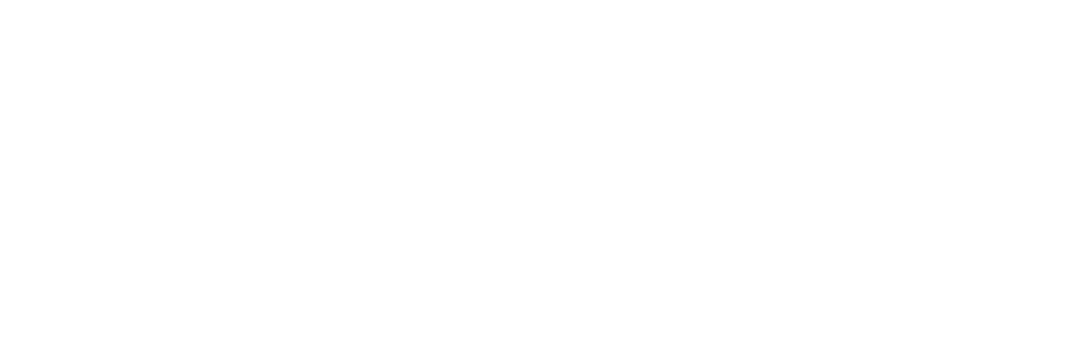

(-0.051412185318944745, 0.0763615487969824)

In [13]:
%matplotlib notebook
#%matplotlib notebook

# Thresholds computing on FFT signal
thr_searcher(sig1_high, Xdata=t, low_sigmas=5, nbins=1000)

<IPython.core.display.Javascript object>


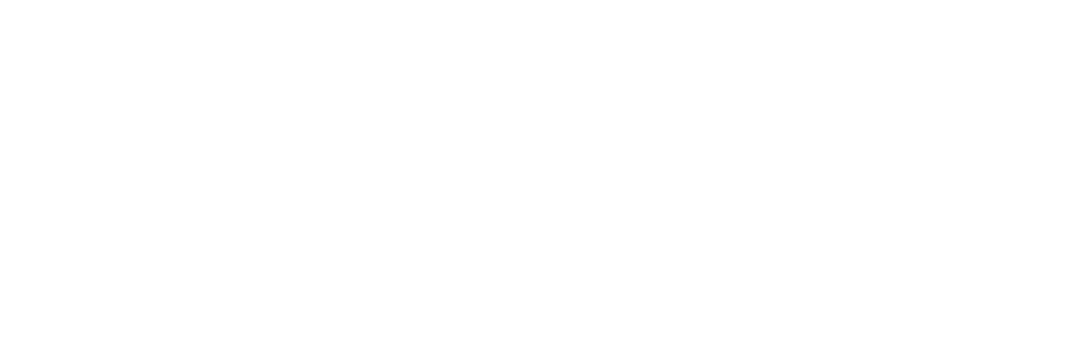

(-0.8834224424738636, 0.8210562248825439)

In [14]:
%matplotlib notebook
# %matplotlib notebook

# Thresholds computing on the rectified signal
thr_searcher(r_sig, nbins=1000, high_sigmas=5, low_sigmas=3, Xdata=t)

### Signal 2

<IPython.core.display.Javascript object>


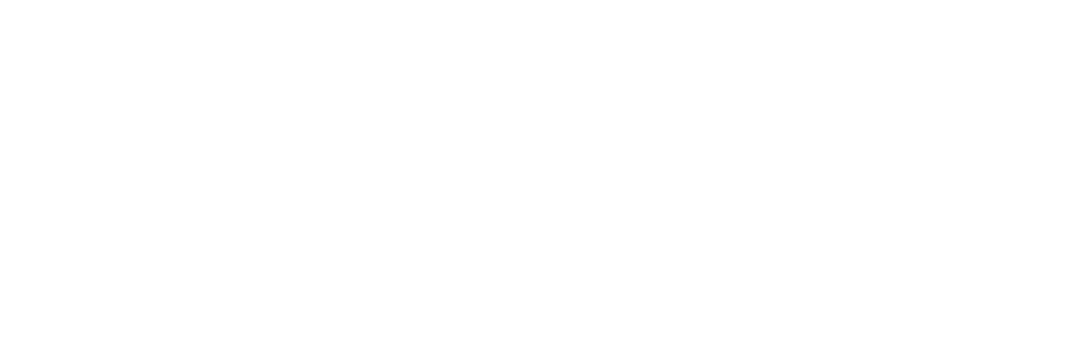

(-0.17055700706370408, 0.2307026369648535)

In [15]:
%matplotlib notebook
# %matplotlib notebook

# Thresholds computing on FFT signal
thr_searcher(sig2_high, nbins=1000, Xdata = t)

<IPython.core.display.Javascript object>


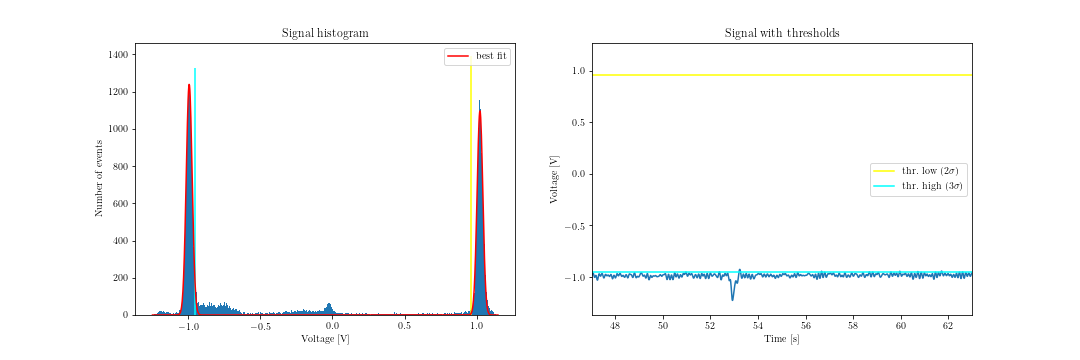

(-0.9549046754184263, 0.9589102493519257)

In [16]:
%matplotlib notebook
# %matplotlib notebook

# Thresholds computing on the rectified signal
thr_searcher(r_sig2, nbins=1000, high_sigmas=3, low_sigmas=2, Xdata=t)